In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory
from mpl_toolkits.mplot3d import Axes3D

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor


def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        original_noise=True,
        action_clipper=[-10., 10.],
        tau_clipper=[0.001, 1.],
        params_logging=False,
        gradient_logging=False,
        batch_size=128,
    )
    return agent

In [4]:
# agent compilation
l = 1.
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)

In [5]:
def value_function_ap(state, agent):
    # Q(s,a)
    assert agent.compiled == True
    state_ = np.array([[state]])
    action_ = agent.actor.predict(state_)
    value_function = agent.critic.predict([action_, state_])[0][0] #Q(a,s)
    return value_function

def value_function(state, agent, step_limit=5000):
    # accumulated reward
    gamma = 0.99
    env.reset()
    env.set_state = state
    episode_reward = 0
    for steps in range(step_limit):
        reward = 0
        x = env.state
        a_agent, tau = agent.forward(x)
        action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.05
        dt = tau / action_repetition
        for p in range(action_repetition):
            _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
            reward += r
        reward *= dt
        reward += - tau * 0.01 * a_agent**2 + l * tau # step reward

        episode_reward += pow(gamma, steps) * reward
    return episode_reward

def value_for_one_state(action, agent, state=np.array([0., 0.])):
    # Q(const, a)
    assert agent.compiled == True
    state_ = np.array([[state]])
    action_ = np.array([action])
    value_function = agent.critic.predict([action_, state_])[0][0] #Q(a,s)
    return value_function

def learned_Q(state, action, agent, env):
    # r(s,a) + gamma*V(s')
    env.reset()
    env.set_state(state)
    
    reward = 0
    gamma = 0.99
    a_agent, tau = action
    action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.05
    dt = tau / action_repetition
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - tau * 0.01 * a_agent**2 + l * tau # step reward
    
    next_state = env.state
    next_value = value_function_ap(next_state, agent) # 学習できていないstateに行った時は間違ったvalueになるはず
    
    return reward + gamma * next_value

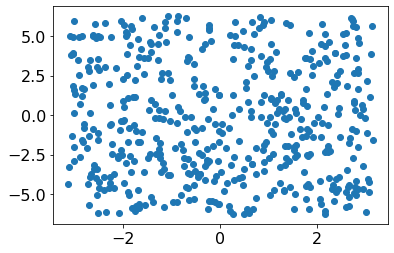

In [27]:
# sample_state
with open('./csv/state_batch.csv', 'r') as f:
    reader = csv.reader(f)
    state_batch = np.array([row for row in reader]).astype('float')
plt.scatter(state_batch[:,0], state_batch[:,1])

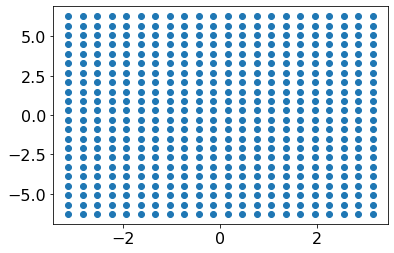

In [64]:
th = np.linspace(-np.pi, np.pi, 22)
th_dot = np.linspace(-2*np.pi, 2*np.pi, 22)
state_batch = []
for t in th:
    for td in th_dot:
        state_batch.append([t,td])
state_batch = np.array(state_batch)
plt.scatter(state_batch[:,0], state_batch[:,1])

## いい感じagentに対するcriticの近似精度

In [34]:
a.load_weights('./saved_agent/learned_self_clipped.h5')

In [35]:
with open('./csv/v_aps.csv', 'r') as f:
    reader = csv.reader(f)
    v_aps = np.array([r for r in reader]).astype('float')[0]

with open('./csv/vs.csv', 'r') as f:
    reader = csv.reader(f)
    vs = np.array([r for r in reader]).astype('float')[0]

In [37]:
v_apss = []
a.critic.load_weights('./saved_agent/learned_self_clipped_critic_supervised.h5')
for state in state_batch:
    v_apss.append(value_function_ap(state, a))

v_apss = np.array(v_apss)

<IPython.core.display.Javascript object>


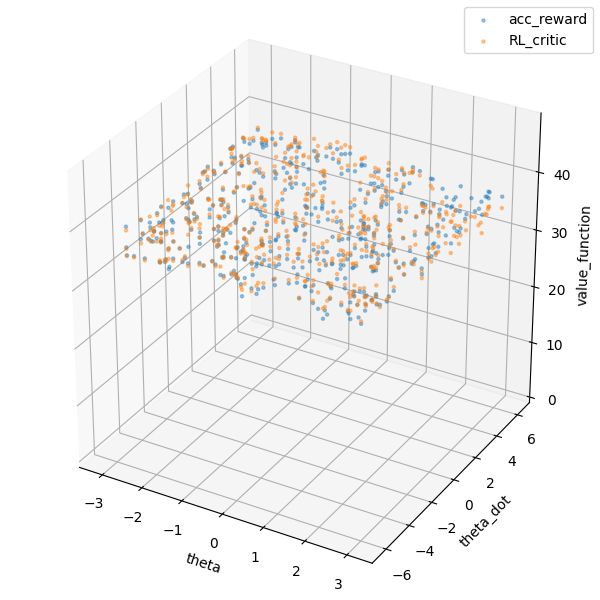

In [39]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('value_function')

ax.scatter3D(state_batch[:,0], state_batch[:,1], vs, marker='.', alpha=0.4, label='acc_reward')
ax.scatter3D(state_batch[:,0], state_batch[:,1], v_apss, marker='.', alpha=0.4, label='RL_critic')
# ax.scatter3D(state_batch[:,0], state_batch[:,1], v_inits, marker='.', alpha=0.4, label='initial_critic')
ax.set_zlim(0,49)
plt.legend()

## 比較: 0.01サンプル値agentに対するcriticの近似

In [11]:
a.load_weights('./saved_agent/learned_from_001.h5')

In [12]:
with open('./csv/v_aps_001.csv', 'r') as f:
    reader = csv.reader(f)
    v_aps_001 = np.array([r for r in reader]).astype('float')[0]

with open('./csv/vs_001.csv', 'r') as f:
    reader = csv.reader(f)
    vs_001 = np.array([r for r in reader]).astype('float')[0]

In [21]:
# initital ciritic
# 初期criticからちゃんと学習進んでる？？

initial_critic = critic_net((2,),(2,))[0]
v_inits_001 = []

for i, state in enumerate(state_batch):
    print(f'{int(i/5)}%\r',end='')
    state_ = np.array([[state]])
    action_ = a.actor.predict(state_)
    vf = initial_critic.predict([action_, state_])[0][0] #Q(a,s)
    v_inits_001.append(vf)

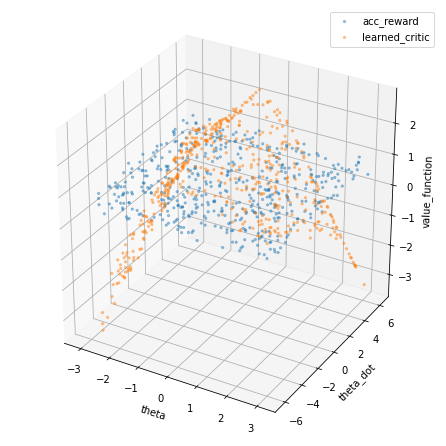

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('value_function')

ax.scatter3D(state_batch[:,0], state_batch[:,1], vs_001, marker='.', alpha=0.4, label='acc_reward')
ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps_001, marker='.', alpha=0.4, label='critic')
# ax.scatter3D(state_batch[:,0], state_batch[:,1], v_inits_001, marker='.', alpha=0.4, label='initial_critic')
plt.legend()

## 比較: 0.2サンプル値agentに対するcriticの近似

In [72]:
a.actor.load_weights('./saved_agent/sample_02.h5')
a.critic.load_weights('./saved_agent/sample_02_supervised.h5')

In [73]:
with open('./csv/vs_02.csv', 'r') as f:
    reader = csv.reader(f)
    vs_02 = np.array([r for r in reader]).astype('float')[0]

v_aps_02 = []
for state in state_batch:
    v_aps_02.append(value_function_ap(state, a))

v_aps_02 = np.array(v_aps_02)

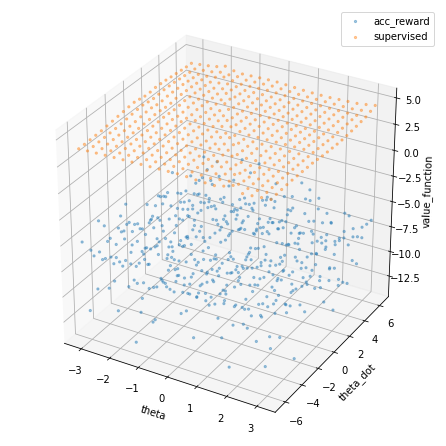

In [75]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('value_function')

ax.scatter3D(state_batch[:,0], state_batch[:,1], vs_02, marker='.', alpha=0.4, label='acc_reward')
ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps_02, marker='.', alpha=0.4, label='supervised')
#ax.set_zlim(0,10)
plt.legend()

In [62]:
# evaluation function comparison

lim = np.array([np.pi, 2*np.pi])
batch_size = 100
Jrls, J02s, Jrl4s, Jrl6s, Jrl7s = [], [], [], [], []

for i in range(250):
    states = []
    J_rl, J_02, J_rl4, J_rl6, J_rl7 = 0, 0, 0, 0, 0
    for _ in range(batch_size):
        states.append(np.random.uniform(low=-lim, high=lim))
    states = np.array(states)
    a.actor.load_weights('./saved_agent/learned_self_clipped_actor.h5')
    a.critic.load_weights('./saved_agent/learned_self_clipped_critic_supervised.h5')
    for state in states:
        J_rl += value_function_ap(state, a) / batch_size
    a.actor.load_weights('./saved_agent/sample_02.h5')
    a.critic.load_weights('./saved_agent/sample_02_supervised.h5')
    for state in states:
        J_02 += value_function_ap(state, a) / batch_size
    a.actor.load_weights('./saved_agent/learned_self_clipped4_actor.h5')
    a.critic.load_weights('./saved_agent/learned_self_clipped4_critic_supervised.h5')
    for state in states:
        J_rl4 += value_function_ap(state, a) / batch_size
    a.actor.load_weights('./saved_agent/learned_self_clipped6_actor.h5')
    a.critic.load_weights('./saved_agent/learned_self_clipped6_critic_supervised.h5')
    for state in states:
        J_rl6 += value_function_ap(state, a) / batch_size
    a.actor.load_weights('./saved_agent/learned_self_clipped7_actor.h5')
    a.critic.load_weights('./saved_agent/learned_self_clipped7_critic_supervised.h5')
    for state in states:
        J_rl7 += value_function_ap(state, a) / batch_size
    Jrls.append(J_rl)
    J02s.append(J_02)
    Jrl4s.append(J_rl4)
    Jrl6s.append(J_rl6)
    Jrl7s.append(J_rl7)

In [63]:
print(np.mean(Jrls), np.sqrt(np.var(Jrls)))
print(np.mean(J02s), np.sqrt(np.var(J02s)))
print(np.mean(Jrl4s), np.sqrt(np.var(Jrl4s)))
print(np.mean(Jrl6s), np.sqrt(np.var(Jrl6s)))
print(np.mean(Jrl7s), np.sqrt(np.var(Jrl7s)))

37.11865823028564 0.08460586642283373
4.233751683330536 0.009386042003894274
48.22910731277466 0.05742874727523332
70.20220516510011 0.07207861035681407
70.7138681602478 0.130886930922523


In [ ]:
print(np.mean(Jrls), np.sqrt(np.var(Jrls)))
print(np.mean(J02s), np.sqrt(np.var(J02s)))
print(np.mean(Jrl4s), np.sqrt(np.var(Jrl4s)))
print(np.mean(Jrl5s), np.sqrt(np.var(Jrl5s)))

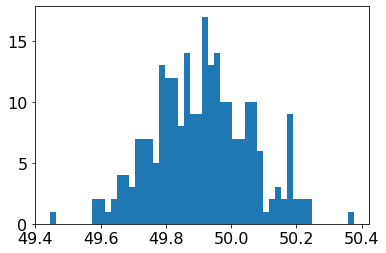

In [94]:
plt.hist(Jrl5s, bins=50)
plt.show()

## $Q(s, \pi(s)) - \{(r(s, \pi(s)) + \gamma Q(s^{\prime}, \pi(s^{\prime}))\}$を計算してみる

In [ ]:
# もう一度いい感じagentで
a.load_weights('./saved_agent/learned_self4.h5')

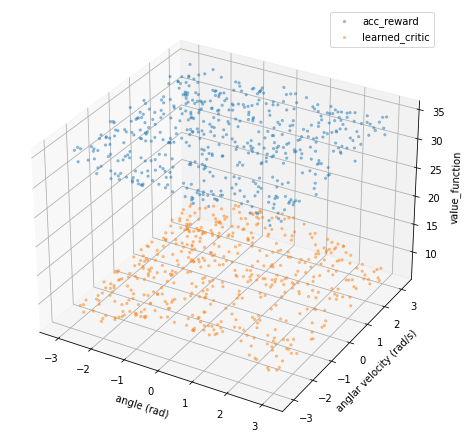

In [70]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('angle (rad)')
ax.set_ylabel('anglar velocity (rad/s)')
ax.set_zlabel('value_function')

ax.scatter3D(state_batch[:,0], state_batch[:,1], vs, marker='.', alpha=0.4, label='acc_reward')
ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps, marker='.', alpha=0.4, label='RL_critic')
plt.legend()

In [58]:
def TD_error(state0, state1, agent):
    gamma = 0.99
    reward = 0
    
    # left hand side
    left = value_function_ap(state0, agent)
    
    # caluculate reward r(s, π(s))
    env.reset()
    env.set_state(state0)
    a_agent, tau = agent.forward(state0)
    action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.05
    dt = tau / action_repetition
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - tau * 0.01 * a_agent**2 + l * tau # step reward
    
    # right hand side
    right = reward + gamma * value_function_ap(state1, agent)
    return left - right

In [34]:
with open('./csv/replay_buffer.csv', 'r') as f:
    reader = csv.reader(f)
    replay_buffer = np.array([r for r in reader]).astype('float')

In [61]:
batch_size = 128
idxs = np.random.choice(np.array(range(len(replay_buffer))), batch_size, replace=False)

states = replay_buffer[idxs]

tds = []
for i in range(len(states)-1):
    tds.append(TD_error(states[i], states[i+1], a)**2)

print(np.average(tds))

0.13392293556399043


In [69]:
# process_noiseが乗っていないので、安定化が実現してからのtauの変化を学習することができなくなっている

## 方策固定して教師あり学習したcriticをみてみる
supervised_dist は 一番(s,a)の分散がでかい<br>
supervised2 は $\tau, u$の両方にノイズを載せた<br>
supervised は $(s, \pi(s))$で学習<br>

In [41]:
# load agent
a.actor.load_weights('./saved_agent/learned_self_clipped2_actor.h5')
a.critic.load_weights('./saved_agent/learned_self_clipped2_critic_supervised.h5')

In [38]:
v_aps2 = []

for state in state_batch:
    v_aps2.append(value_function_ap(state, a))
    
v_aps2 = np.array(v_aps2)

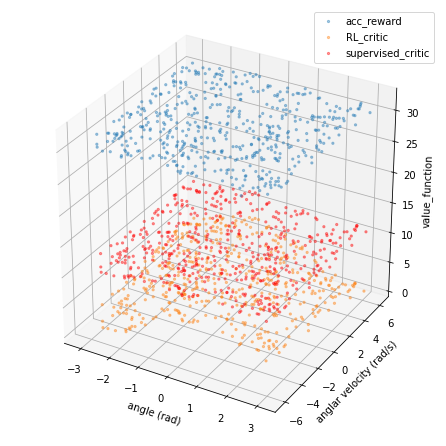

In [39]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib notebook

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('angle (rad)')
ax.set_ylabel('anglar velocity (rad/s)')
ax.set_zlabel('value_function')

ax.scatter3D(state_batch[:,0], state_batch[:,1], vs, marker='.', alpha=0.4, label='acc_reward')
ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps, marker='.', alpha=0.4, label='RL_critic')
ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps2, marker='.', alpha=0.4, label='supervised_critic', color='red')
plt.legend()
plt.show()

In [68]:
# load agent
a.actor.load_weights('./saved_agent/learned_self_clipped3_actor.h5')
a.critic.load_weights('./saved_agent/learned_self_clipped3_critic_supervised.h5')

In [69]:
with open('./csv/v_aps3.csv', 'r') as f:
    reader = csv.reader(f)
    v_aps = np.array([r for r in reader]).astype('float')[0]

with open('./csv/vs3.csv', 'r') as f:
    reader = csv.reader(f)
    vs = np.array([r for r in reader]).astype('float')[0]

v_aps2 = []
    
for state in state_batch:
    v_aps2.append(value_function_ap(state, a))
    
v_aps2 = np.array(v_aps2)

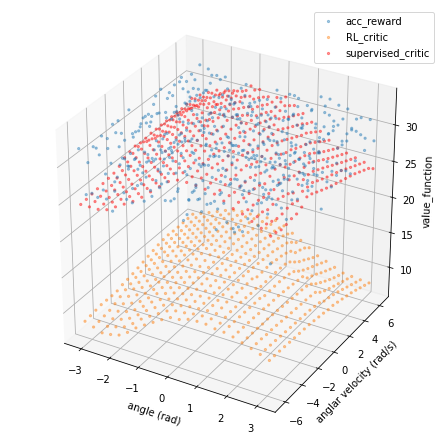

In [71]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib notebook

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('angle (rad)')
ax.set_ylabel('anglar velocity (rad/s)')
ax.set_zlabel('value_function')

ax.scatter3D(state_batch[:,0], state_batch[:,1], vs, marker='.', alpha=0.4, label='acc_reward')
ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps, marker='.', alpha=0.4, label='RL_critic')
ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps2, marker='.', alpha=0.4, label='supervised_critic', color='red')
plt.legend()
plt.show()

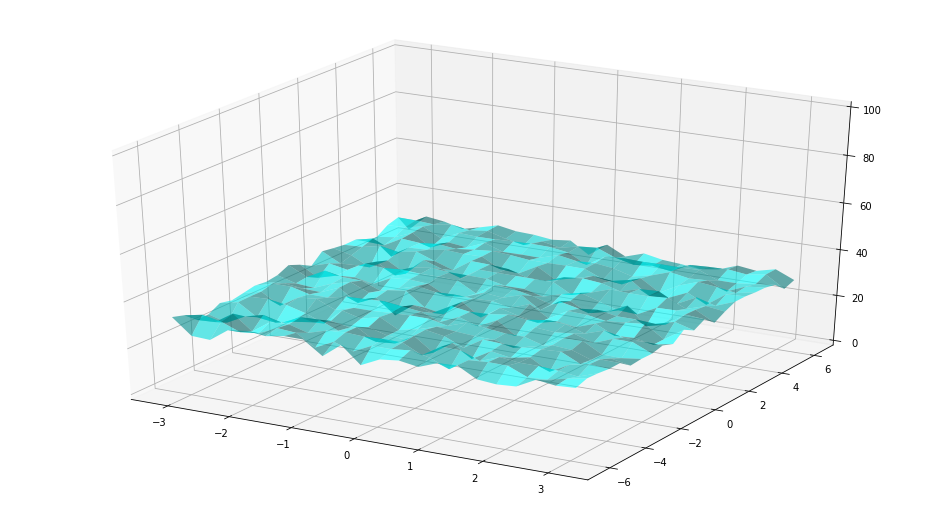

In [97]:
th = np.linspace(-np.pi, np.pi,22)
th_dot = np.linspace(-2*np.pi, 2*np.pi,22)
Th,Thd = np.meshgrid(th,th_dot)
vs_m = vs.reshape(Th.shape)
v_aps_m = v_aps2.reshape(Th.shape)


fig = plt.figure(figsize=(13,7))
ax = Axes3D(fig)
ax.set_zlim(0,100)
ax.plot_surface(Th, Thd, vs_m, alpha=0.6, label='recurrence_formula', color='cyan')
#ax.plot_surface(Th, Thd, v_aps_m, alpha=0.6, label='recurrence_formula', color='green')


plt.show()

#ax = plt.subplot(111)
#ax.pcolormesh(Th, Thd, vs_m, cmap='seismic')
#plt.show()

In [65]:
# load agent
a.actor.load_weights('./saved_agent/learned_self_clipped6_actor.h5')
a.critic.load_weights('./saved_agent/learned_self_clipped6_critic_supervised.h5')

In [66]:
v_aps2 = []
    
for state in state_batch:
    v_aps2.append(value_function_ap(state, a))
    
v_aps2 = np.array(v_aps2)

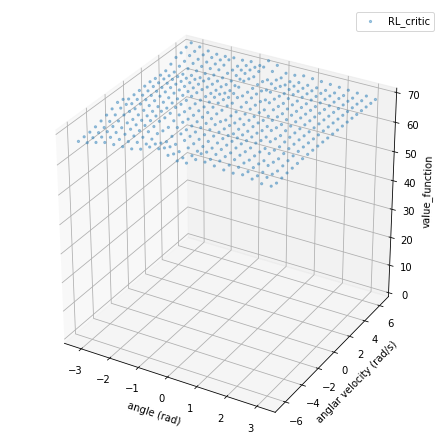

In [67]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib notebook

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('angle (rad)')
ax.set_ylabel('anglar velocity (rad/s)')
ax.set_zlabel('value_function')

ax.scatter3D(state_batch[:,0], state_batch[:,1], v_aps2, marker='.', alpha=0.4, label='RL_critic')
ax.set_zlim(0,70)
plt.legend()
plt.show()

# s固定時のQ関数のaに関する微分は？
$f_{const}(a) = Q(const, a)$

In [55]:
high = np.array([10., 1.])
low = np.array([-10., 0.01])

action_batch = []
for i in range(500):
    action_batch.append(np.random.uniform(low=low, high=high))
    
action_batch = np.array(action_batch)

In [66]:
const_state_Q = []
const_state_Q_supervised = []

const_state = np.array([0, 0])

a.critic.load_weights('./saved_agent/learned_self_clipped2_critic.h5')
for action in action_batch:
    const_state_Q.append(value_for_one_state(action, a, const_state))

a.critic.load_weights('./saved_agent/learned_self_clipped2_critic_supervised.h5')
for action in action_batch:
    const_state_Q_supervised.append(value_for_one_state(action, a, const_state))

const_state_Q, const_state_Q_supervised = np.array(const_state_Q), np.array(const_state_Q_supervised)

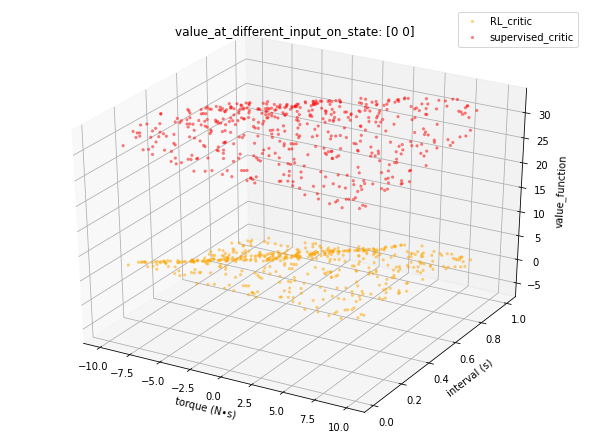

In [69]:
%matplotlib inline
# %matplotlib notebook

fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig)
ax.set_xlabel('torque (N•s)')
ax.set_ylabel('interval (s)')
ax.set_zlabel('value_function')

ax.scatter3D(action_batch[:,0], action_batch[:,1], const_state_Q, marker='.', alpha=0.4, label='RL_critic', color='orange')
ax.scatter3D(action_batch[:,0], action_batch[:,1], const_state_Q_supervised, marker='.', alpha=0.4, label='supervised_critic', color='red')
ax.set_title(f'value_at_different_input_on_state: {const_state}')
plt.legend()

In [ ]:
#これのvaluefunctionで計算したQ関数版

### ↑関数としての値は全然違うけど、関数の形は似ている！(=微分は似た値が出てくる！) (拡大したらちゃんとなってる)
・だからと言ってcriticの近似精度が悪いことは変わりない事実
・関数の形の意味のわかる形なので、蓄積rewardの方が間違っている可能性が高い

# 正しいQ関数を求める
## $Q(s,a) = r(s,a) + \gamma V(s^{\prime})$

In [102]:
a.actor.load_weights('./saved_agent/learned_self_clipped4_actor.h5')

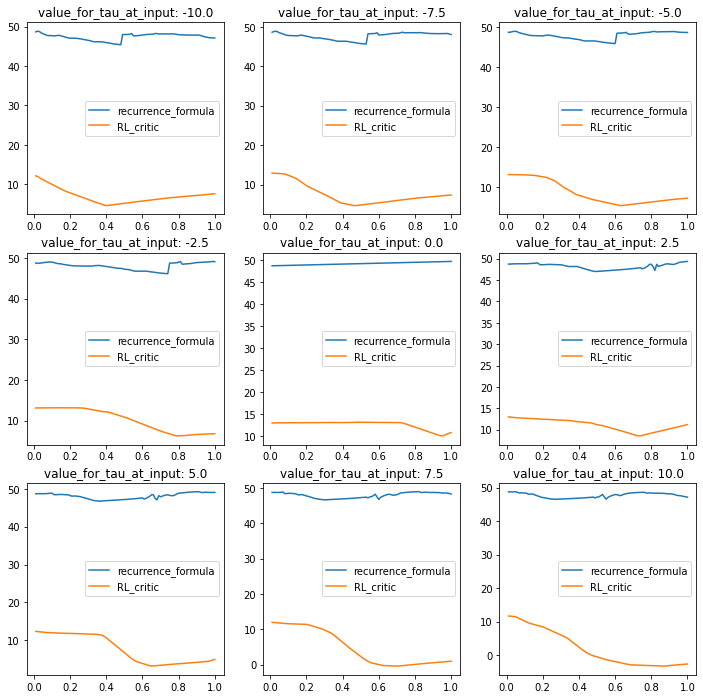

In [103]:
%matplotlib inline
taus = np.linspace(0.01,1.0,100)
inputs = np.linspace(-10, 10, 9)
state = np.array([.0,.0])

plt.figure(figsize=(12,12))
for i, inp in enumerate(inputs):
    plt.subplot(3,3,i+1)
    fq = []
    #fs = []
    fl = []
    for tau in taus:
        action = np.array([inp, tau])
        a.critic.load_weights('./saved_agent/learned_self_clipped4_critic_supervised.h5') # value function計算用
        fq.append(learned_Q(state, action, a, env))
        a.critic.load_weights('./saved_agent/learned_self_clipped4_critic.h5')
        fl.append(value_for_one_state(action, a, state=state))
    plt.plot(taus, fq, label='recurrence_formula')
    plt.plot(taus, fl, label='RL_critic')
    plt.title(f'value_for_tau_at_input: {inp}')
    plt.legend()
plt.show()

## 3つの教師データに対する学習結果の比較
supervised : $V(s)$を一番よく近似できる$Q(s,a)$を近似できた($(s,\pi(s))$の組みに対してだけのoverfit) <br>
supervised2 : $Q(s,a)$が入力信号が$\pi(s)$に近いところのみ, $\tau$の変化を正しく表現できた. <br>
supervised_dist : $V(s)$を最も近似できなかったが, $Q(s,a)$は満遍なく学習できた. ただ, 値が違うのがよくわからない.

探索と活用のジレンマを、最も効率をあげたい<br>
後ろのホワイトボードに案を書いている

## $f_{const}(a) = Q(const,a)$を, 正しいQ関数で

In [56]:
a.actor.load_weights('./saved_agent/learned_self_clipped3_actor.h5')

In [54]:
action = np.arange(-10., 10., 0.2)            # x軸を作成
tau = np.arange(0.01, 1., 0.0099)            # y軸を作成
A, T = np.meshgrid(action, tau)             # x軸とy軸からグリッドデータを作成

const_state_Q = []
const_state_Q_supervised = []
comparison = []
const_state_Q_recurrence = []

const_state = np.array([0.0, 0.0])

a.critic.load_weights('./saved_agent/learned_self_clipped3_critic.h5')
for ac, t in zip(A.flatten(), T.flatten()):
    action = np.array([ac, t])
    const_state_Q.append(value_for_one_state(action, a, const_state))

'''
a.critic.load_weights('./saved_agent/learned_self_clipped3_critic_supervised_dist.h5')
for ac, t in zip(A.flatten(), T.flatten()):
    action = np.array([ac, t])
    const_state_Q_supervised.append(value_for_one_state(action, a, const_state))
'''    

a.critic.load_weights('./saved_agent/learned_self_clipped3_critic_supervised.h5')
for ac, t in zip(A.flatten(), T.flatten()):
    action = np.array([ac, t])
    const_state_Q_recurrence.append(learned_Q(const_state, action, a, env))
    comparison.append(value_for_one_state(action, a, const_state))


comparison = np.array(comparison).reshape(100, 100)
#const_state_Q_supervised = np.array(const_state_Q_supervised).reshape(100, 100)
const_state_Q, const_state_Q_recurrence = np.array(const_state_Q).reshape(100, 100), np.array(const_state_Q_recurrence).reshape(100, 100)

In [50]:
pi_s = a.actor.predict(np.array([[[1.0, 2.0]]]))
pi_s

array([[-9.999998  ,  0.21676673]], dtype=float32)

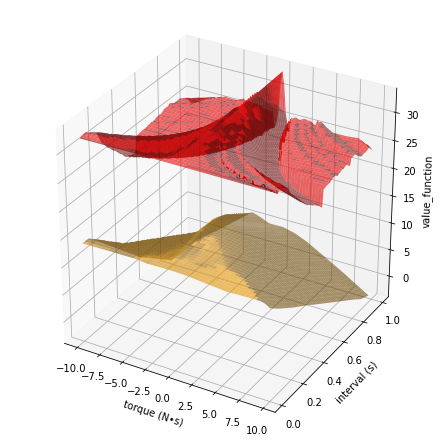

In [10]:
%matplotlib inline
#%matplotlib notebook


fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('torque (N•s)')
ax.set_ylabel('interval (s)')
ax.set_zlabel('value_function')

ax.plot_surface(A, T, const_state_Q_recurrence, alpha=0.6, label='recurrence_formula', color='red')
#ax.plot_surface(A, T, const_state_Q_supervised, alpha=0.6, label='supervised_critic_dist', color='cyan', cmap='plasma')
#ax.plot_surface(A, T, comparison, alpha=0.6, label='supervised_critic_episodic', color='magenta')
ax.plot_surface(A, T, const_state_Q, alpha=0.6, label='RL_learned_critic', color='orange')
#plt.legend()

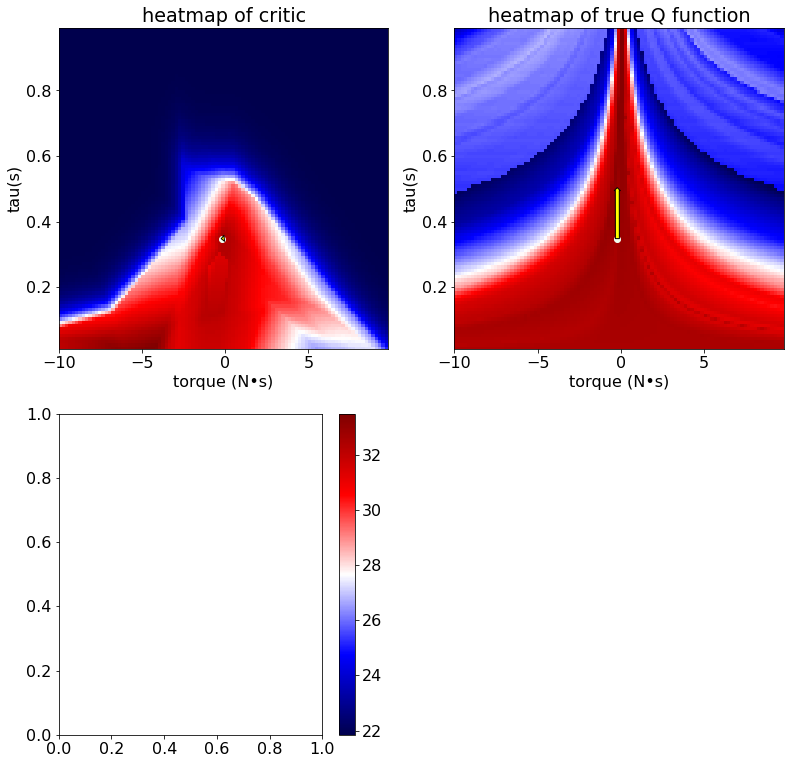

In [13]:
# heat map
action = a.actor.predict(np.array([[[0.0,0.0]]]))[0]
plt.figure(figsize=(13,13))
plt.rcParams["font.size"] = 16
ax1 = plt.subplot(221)
im1 = ax1.pcolormesh(A, T, np.exp(const_state_Q), cmap='seismic')
ax1.scatter([action[0]], [action[1]], color='honeydew')
am, tm = np.gradient(const_state_Q ,.2, .2)
am, tm = .03*am[71,48], .03*tm[71,48]
ax1.annotate('',
        xy=(action[0]+am, action[1]+tm), xycoords='data',
        xytext=(action[0], action[1]), textcoords='data', fontsize=0,
        arrowprops=dict(shrink=100,width=4,headwidth=6,headlength=3,
                        connectionstyle='arc3',facecolor='yellow',edgecolor='black'))

ax1.set_xlabel('torque (N•s)')
ax1.set_ylabel('tau(s)')
ax1.set_title('heatmap of critic')
ax2 = plt.subplot(222)
im2 = ax2.pcolormesh(A, T, const_state_Q_recurrence,cmap='seismic')

ax2.scatter([action[0]], [action[1]], color='honeydew')
am, tm = np.gradient(const_state_Q_recurrence ,.2, .2)
am, tm = .03*am[71,48], .03*tm[71,48]
ax2.annotate('',
        xy=(action[0]+am, action[1]+tm), xycoords='data',
        xytext=(action[0], action[1]), textcoords='data', fontsize=0,
        arrowprops=dict(shrink=10,width=4,headwidth=6,headlength=3,
                        connectionstyle='arc3',facecolor='yellow',edgecolor='black'))
ax2.set_xlabel('torque (N•s)')
ax2.set_ylabel('tau(s)')
ax2.set_title('heatmap of true Q function')
ax3 = plt.subplot(223)

plt.colorbar(im2)

0.021436214 0.019750595


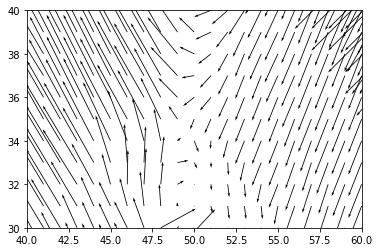

In [326]:
am, tm = np.gradient(const_state_Q ,.2, .2)#[0][0,49], np.gradient(const_state_Q ,.2, .2)[1][34,0] # 49, 34 ##print(A[0,49], T[34,0])
am[am>0.5],tm[tm>0.5] = 0.5, 0.5    # 勾配の上限下限
am[am<-0.5],tm[tm<-0.5] = -0.5, -0.5
plt.quiver(am,tm,scale=2)
print(am[34,49], tm[34,49])
plt.xlim(40,60)
plt.ylim(30,40)
plt.show()

In [19]:
action = np.arange(-10., 10., 0.2)            # x軸を作成
tau = np.arange(0.01, 1., 0.0099)            # y軸を作成
A, T = np.meshgrid(action, tau)             # x軸とy軸からグリッドデータを作成

const_state_Q = []
const_state_Q_recurrence = []

const_state = np.array([0.0, 0.0])
a.actor.load_weights('./saved_agent/learned_self_clipped7_actor.h5')

a.critic.load_weights('./saved_agent/learned_self_clipped7_critic.h5')
for ac, t in zip(A.flatten(), T.flatten()):
    action = np.array([ac, t])
    const_state_Q.append(value_for_one_state(action, a, const_state))

a.critic.load_weights('./saved_agent/learned_self_clipped7_critic_supervised.h5')
for ac, t in zip(A.flatten(), T.flatten()):
    action = np.array([ac, t])
    const_state_Q_recurrence.append(learned_Q(const_state, action, a, env))


const_state_Q, const_state_Q_recurrence = np.array(const_state_Q).reshape(100, 100), np.array(const_state_Q_recurrence).reshape(100, 100)

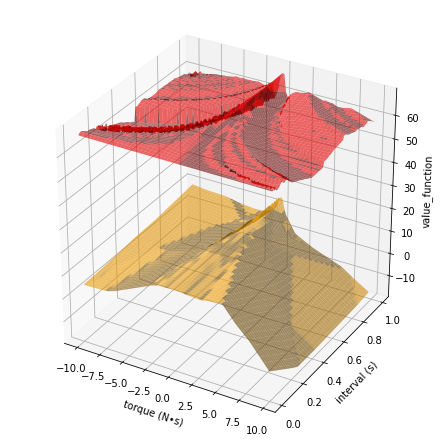

In [20]:
%matplotlib inline
#%matplotlib notebook


fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('torque (N•s)')
ax.set_ylabel('interval (s)')
ax.set_zlabel('value_function')

ax.plot_surface(A, T, const_state_Q, alpha=0.6, color='orange')
ax.plot_surface(A, T, const_state_Q_recurrence, alpha=0.6, label='recurrence_formula', color='red')

#plt.legend()

[-0.10378881  0.9776606 ]


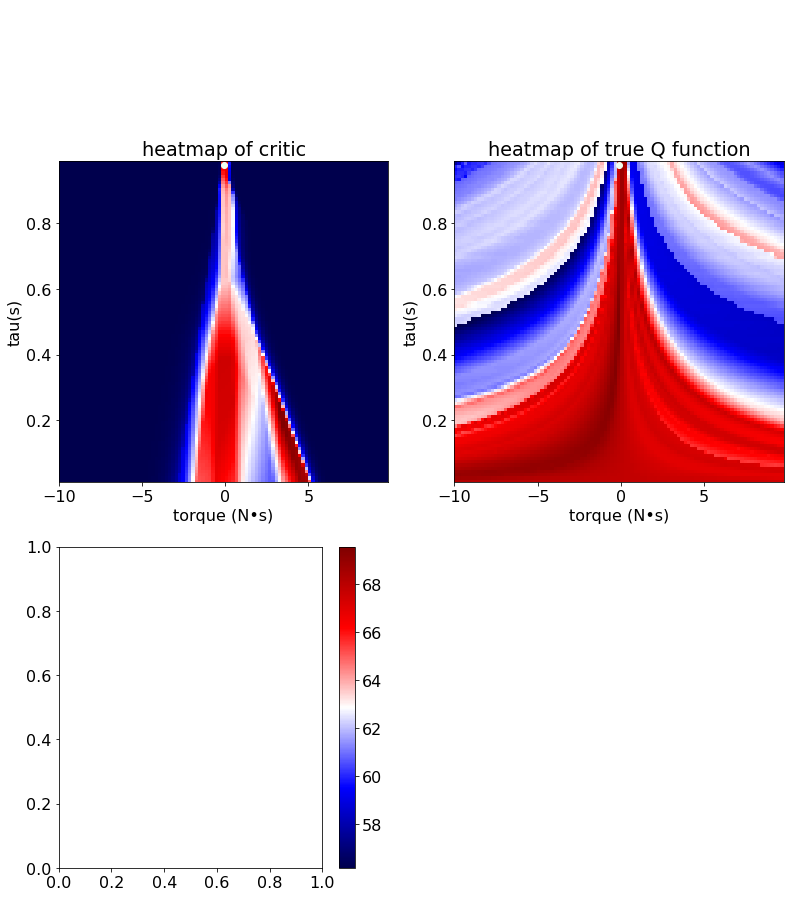

In [24]:
# heat map 7
action = a.actor.predict(np.array([[[0.0,0.0]]]))[0]
print(action)
plt.figure(figsize=(13,13))
plt.rcParams["font.size"] = 16
ax1 = plt.subplot(221)
im1 = ax1.pcolormesh(A, T, np.exp(const_state_Q), cmap='seismic')
ax1.scatter([action[0]], [action[1]], color='honeydew')
am, tm = np.gradient(const_state_Q ,.2, .2)
am, tm = .03*am[97,48], .03*tm[97,48]
ax1.annotate('',
        xy=(action[0]+am, action[1]+tm), xycoords='data',
        xytext=(action[0], action[1]), textcoords='data', fontsize=0,
        arrowprops=dict(shrink=100,width=4,headwidth=6,headlength=3,
                        connectionstyle='arc3',facecolor='yellow',edgecolor='black'))

ax1.set_xlabel('torque (N•s)')
ax1.set_ylabel('tau(s)')
ax1.set_title('heatmap of critic')
ax2 = plt.subplot(222)
im2 = ax2.pcolormesh(A, T, const_state_Q_recurrence,cmap='seismic')

ax2.scatter([action[0]], [action[1]], color='honeydew')
am, tm = np.gradient(const_state_Q_recurrence ,.2, .2)
am, tm = .03*am[97,48], .03*tm[97,48]
ax2.annotate('',
        xy=(action[0]+am, action[1]+tm), xycoords='data',
        xytext=(action[0], action[1]), textcoords='data', fontsize=0,
        arrowprops=dict(shrink=10,width=4,headwidth=6,headlength=3,
                        connectionstyle='arc3',facecolor='yellow',edgecolor='black'))
ax2.set_xlabel('torque (N•s)')
ax2.set_ylabel('tau(s)')
ax2.set_title('heatmap of true Q function')
ax3 = plt.subplot(223)

plt.colorbar(im2)

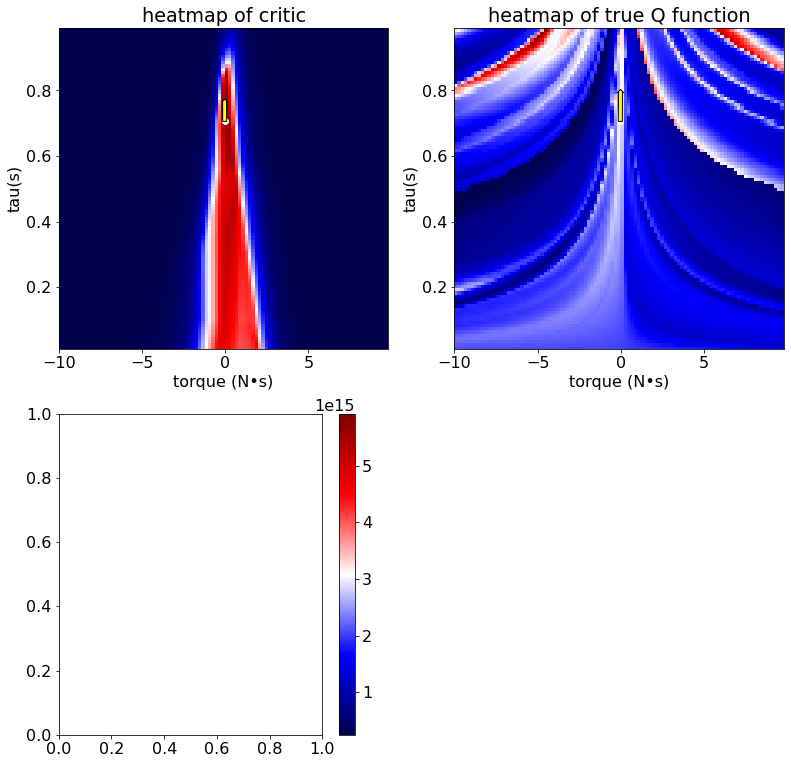

In [53]:
# heat map 6
action = a.actor.predict(np.array([[[0.0,0.0]]]))[0]
plt.figure(figsize=(13,13))
plt.rcParams["font.size"] = 16
ax1 = plt.subplot(221)
im1 = ax1.pcolormesh(A, T, np.exp(const_state_Q), cmap='seismic')
ax1.scatter([action[0]], [action[1]], color='honeydew')
am, tm = np.gradient(const_state_Q ,.2, .2)
am, tm = .03*am[71,48], .03*tm[71,48]
ax1.annotate('',
        xy=(action[0]+am, action[1]+tm), xycoords='data',
        xytext=(action[0], action[1]), textcoords='data', fontsize=0,
        arrowprops=dict(shrink=100,width=4,headwidth=6,headlength=3,
                        connectionstyle='arc3',facecolor='yellow',edgecolor='black'))

ax1.set_xlabel('torque (N•s)')
ax1.set_ylabel('tau(s)')
ax1.set_title('heatmap of critic')
ax2 = plt.subplot(222)
im2 = ax2.pcolormesh(A, T, np.exp(0.5*const_state_Q_recurrence),cmap='seismic')

ax2.scatter([action[0]], [action[1]], color='honeydew')
am, tm = np.gradient(const_state_Q_recurrence ,.2, .2)
am, tm = .03*am[71,48], .03*tm[71,48]
ax2.annotate('',
        xy=(action[0]+am, action[1]+tm), xycoords='data',
        xytext=(action[0], action[1]), textcoords='data', fontsize=0,
        arrowprops=dict(shrink=10,width=4,headwidth=6,headlength=3,
                        connectionstyle='arc3',facecolor='yellow',edgecolor='black'))
ax2.set_xlabel('torque (N•s)')
ax2.set_ylabel('tau(s)')
ax2.set_title('heatmap of true Q function')
ax3 = plt.subplot(223)

plt.colorbar(im2)

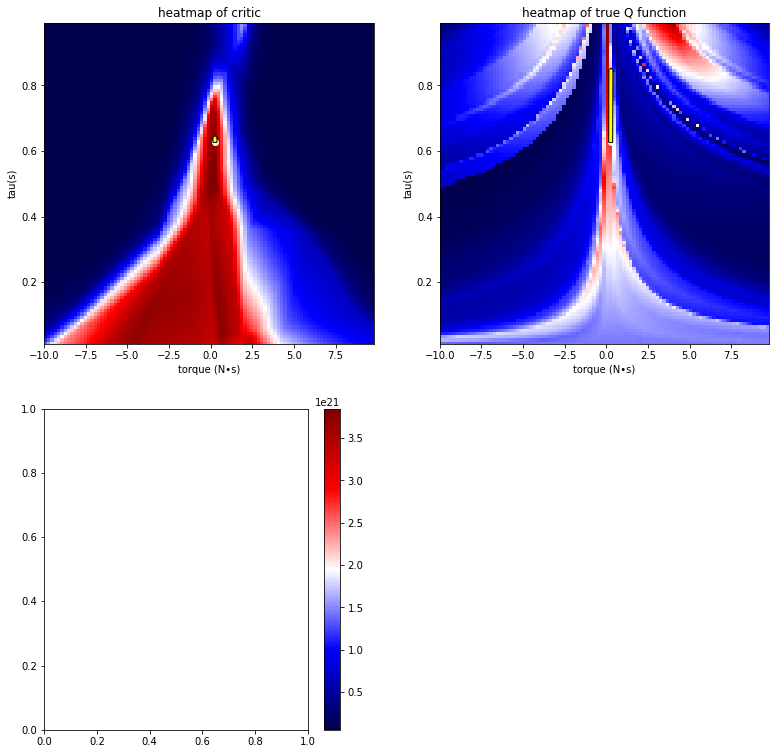

In [42]:
# heat map
action = a.actor.predict(np.array([[[0.0,0.0]]]))[0]
plt.figure(figsize=(13,13))
plt.rcParams["font.size"] = 16
ax1 = plt.subplot(221)
im1 = ax1.pcolormesh(A, T, np.exp(const_state_Q), cmap='seismic')
ax1.scatter([action[0]], [action[1]], color='honeydew')
am, tm = np.gradient(const_state_Q ,.2, .2)
am, tm = .3*am[62,50], .3*tm[62,50]
ax1.annotate('',
        xy=(action[0]+am, action[1]+tm), xycoords='data',
        xytext=(action[0], action[1]), textcoords='data', fontsize=0,
        arrowprops=dict(shrink=100,width=4,headwidth=6,headlength=3,
                        connectionstyle='arc3',facecolor='yellow',edgecolor='black'))

ax1.set_xlabel('torque (N•s)')
ax1.set_ylabel('tau(s)')
ax1.set_title('heatmap of critic')
ax2 = plt.subplot(222)
im2 = ax2.pcolormesh(A, T, np.exp(const_state_Q_recurrence),cmap='seismic')

ax2.scatter([action[0]], [action[1]], color='honeydew')
am, tm = np.gradient(const_state_Q_recurrence ,.2, .2)
am, tm = .3*am[62,50], .3*tm[62,50]
ax2.annotate('',
        xy=(action[0]+am, action[1]+tm), xycoords='data',
        xytext=(action[0], action[1]), textcoords='data', fontsize=0,
        arrowprops=dict(shrink=10,width=4,headwidth=6,headlength=3,
                        connectionstyle='arc3',facecolor='yellow',edgecolor='black'))
ax2.set_xlabel('torque (N•s)')
ax2.set_ylabel('tau(s)')
ax2.set_title('heatmap of true Q function')
ax3 = plt.subplot(223)

plt.colorbar(im2)